/var/folders/v1/xrps7b392_3f75y4rhby8nl00000gn/T/ipykernel_42560/2517380113.py:305: RuntimeWarning: divide by zero encountered in scalar divide
  plt.plot(phiE, np.abs([s.g4 / s.g3 for s in spas]), '--', label='g4/g3')
/var/folders/v1/xrps7b392_3f75y4rhby8nl00000gn/T/ipykernel_42560/2517380113.py:218: RuntimeWarning: divide by zero encountered in scalar divide
  return 2*nbar*self.g4_eff / self.g3


f0 = 5.993 GHz	Ltot = 3.276 nH	Ctot = 0.215 pF
Z = 123.4 Ohm	E_L = 49.891 GHz	E_C = 0.09 GHz
E_L/E_C = 554.3	varphi_zpf = 0.245
M = 1	p = 0.94	L_j = 0.9 nH
g3 = -30.144 MHz	g4 = -0.036 MHz	g4/g3 = 0.001
g5 = 88.811 kHz	g6 = -0.683 kHz
g4_eff = -0.794 MHz	chi_qq = -9.527 MHz
Kerr Cat for nbar = 2.00
K = -0.215 MHz	K_eff = -4.764 MHz
xi for 2 photon cat: 0.11
Gap: -38.108432174246175 MHz
Big junction: 0.9 nH	Small junction: 9.0 nH
L_s = 3.076 nH


FileNotFoundError: [Errno 2] No such file or directory: '/Users/rodrigo/Downloads/fig_g3g4_a0.10_Lj0.900nH_M1_info0.36.txt'

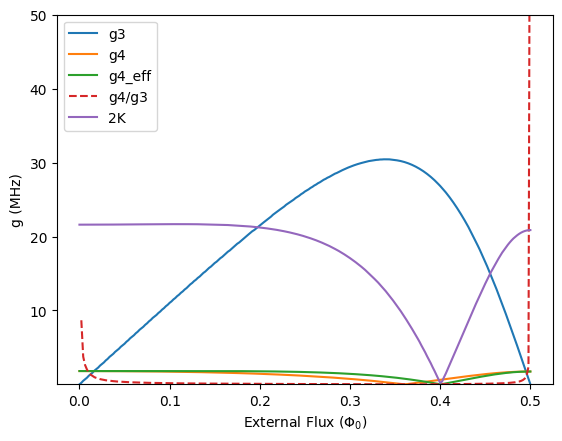

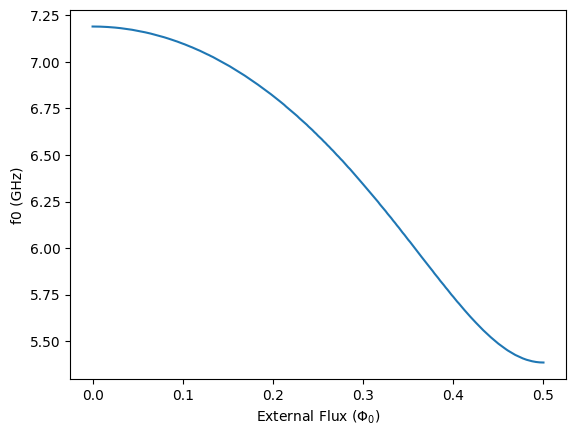

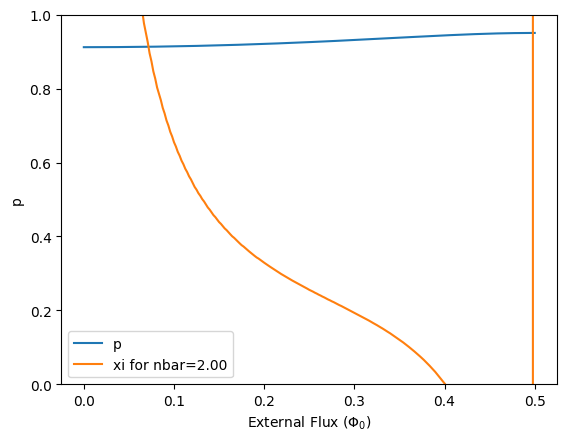

In [1]:
# -*- coding: utf-8 -*-
import os

import numpy as np
import scipy as sc
import qutip as qt
import scipy.constants as const
import math
import scipy as spy

import matplotlib.pyplot as plt
import matplotlib as mpl

h = const.h
ec = const.e
hbar = h/(2*np.pi)
phi0 = hbar/(2*ec)

class Snail:
    def __init__(self, alpha, n, phi_E):
        
        self.alpha = alpha #the ratio Ej/Ejbig between the small junction and big junctions. 
        self.n = n # number of big junctions
        self.phi_E = phi_E # phi_E is the external flux in units of reduced flux quantum
        
        self.phis = np.linspace(-3*np.pi,3*np.pi,10001)
                
    @property
    def i_min(self):
        return list(self.U(self.phis)).index(np.min(self.U(self.phis)))

    @property
    def c2(self):
        return self.U_der2(self.phis[self.i_min])

    @property
    def c3(self):
        return self.U_der3(self.phis[self.i_min])

    @property
    def c4(self):
        return self.U_der4(self.phis[self.i_min])
    
    @property
    def c5(self):
        return self.U_der5(self.phis[self.i_min])
    
    @property
    def c6(self):
        return self.U_der6(self.phis[self.i_min])

    def U(self,phi): 
        return -self.alpha*np.cos(phi) - self.n*np.cos((self.phi_E-phi)/self.n)

    def U_der(self,phi): #derivative of H for calculating Taylor expansion
        return self.alpha*np.sin(phi) - np.sin((self.phi_E-phi)/self.n)

    def U_der2(self,phi): #2nd derivative of H for calculating Taylor expansion
        return self.alpha*np.cos(phi) + (1./self.n)*np.cos((self.phi_E-phi)/self.n)

    def U_der3(self,phi): #3rd derivative of H for calculating Taylor expansion
        return -self.alpha*np.sin(phi) + (1./self.n**2)*np.sin((self.phi_E-phi)/self.n)

    def U_der4(self,phi): #4th derivative of H for calculating Taylor expansion
        return -self.alpha*np.cos(phi) - (1./self.n**3)*np.cos((self.phi_E-phi)/self.n)
    
    def U_der5(self, phi): #5th derivative of U_snail
        return self.alpha * np.sin(phi) - (1./self.n**4)*np.sin((self.phi_E - phi)/self.n)
    
    def U_der6(self, phi): # 6th derivative
        return self.alpha * np.cos(phi) + (1./self.n**5)*np.cos((self.phi_E - phi)/self.n)


class JosephsonJunction:
    @property
    def c2(self):
        return 1
    
    @property
    def c3(self):
        return 0 
    
    @property
    def c4(self):
        return -1
    
    @property
    def c5(self):
        return 0
    
    @property
    def c6(self):
        return 1
    
class Circuit:
    def __init__(self, L, C, n_modes=1):
        self.L = L # assume L and C in SI units
        self.C = C
        self.n_modes = n_modes
        
    @property
    def omega(self):
        return 1 / np.sqrt(self.L * self.C)
    
    @property
    def Z(self):
        return np.sqrt(self.L / self.C)
    
    @property
    def phi_zpf(self):
        return np.sqrt(hbar * self.Z / 2)
    
    @property
    def q_zpf(self):
        return np.sqrt(hbar / (2 * self.Z))
    
    @property
    def E_L(self): #EJ in rad/s
        return phi0**2/(self.L * hbar)
    
    @property
    def E_C(self): # EC in rad / s
        return ec**2 / (2 * self.C * hbar)
           
    @property
    def varphi_zpf(self):
        return np.power(2 * self.E_C / self.E_L, 0.25)
    
    @property
    def n_zpf(self):
        return np.power(self.E_L / (32 * self.E_C), 0.25)
    
    def __str__(self):
        s = 'f0 = ' + str(np.round(self.omega / (2*np.pi) * 1e-9, 3)) + ' GHz'
        s += '\tLtot = ' + str(np.round(self.L * 1e9, 3)) + ' nH'
        s += '\tCtot = ' + str(np.round(self.C * 1e12, 3)) + ' pF'
        s += '\nZ = ' + str(np.round(self.Z, 1)) + ' Ohm'
        s += '\tE_L = ' + str(np.round(self.E_L * 1e-9 / (2*np.pi), 3)) + ' GHz'
        s += '\tE_C = ' + str(np.round(self.E_C * 1e-9 / (2*np.pi), 3)) + ' GHz'
        s += '\nE_L/E_C = ' + str(np.round(self.E_L / self.E_C, 1))
        s += '\tvarphi_zpf = ' + str(np.round(self.varphi_zpf, 3))
        return s

def calc_C(omega, L):
    return 1 / (omega**2 * L)

def calc_L(omega, C):
    return 1 / (omega**2 * C)
    
class SnailCircuit(Circuit):
    def __init__(self, L_lin, C, L_j, snail=Snail(0.1, 3, np.pi), M=1):
        Circuit.__init__(self, L_lin + M*L_j/snail.c2, C)
        self.L_j = L_j      # inductance of big junction of snail
        self.snail = snail  # snail potential
        self.M = M  #number of snails in series
    
    @property
    def E_J(self): #EJ in rad/s
        return phi0**2/(self.L_j * hbar) 
        #TODO - is this a problem??? shouldn't it be L_j
    
    @property
    def L_s(self):
        return self.L_j / self.snail.c2
    
    @property
    def p(self):
        return (self.M * self.L_s / self.L)
    
    @property
    def c2(self):
        return self.p * self.snail.c2 / self.M
    
    @property
    def c3(self):
        return self.p**3 * self.snail.c3 / self.M**2
    
    @property
    def c4(self):
        return self.p**4 / self.M**3 * (self.snail.c4 - 3*self.snail.c3**2 / self.snail.c2 * (1-self.p))
    
    @property
    def c5(self):
        t = self.snail.c5
        t -= 6*self.snail.c3*self.snail.c4 / self.snail.c2 * (1-self.p)
        t += 5 * self.snail.c3**3 / (self.snail.c2**2) * (1-self.p)**2
        return self.p**5 / self.M**4 * t
    
    @property
    def c6(self):
        t = self.snail.c6
        t -= (11 * self.snail.c3 * self.snail.c5 + 6 * self.snail.c4**2) / self.snail.c2 * (1-self.p)
        t += (51 * self.snail.c3**2 * self.snail.c4) / self.snail.c2**2 * (1-self.p)**2
        t -= 35 * self.snail.c3**4 / self.snail.c2**3 * (1-self.p)**3
        return self.p**6 / self.M**5 * t
    
    @property
    def g3(self):
        return self.c3 / math.factorial(3) * self.E_J * self.varphi_zpf**3
    
    @property
    def g4(self):
        return self.c4 / math.factorial(4) * self.E_J * self.varphi_zpf**4
    
    @property
    def g5(self):
        return self.c5 / math.factorial(5) * self.E_J * self.varphi_zpf**5
    
    @property
    def g6(self):
        return self.c6 / math.factorial(6) * self.E_J * self.varphi_zpf**6
    
    @property
    def g4_eff(self):
        return self.g4 - 5*(self.g3**2)/self.omega
    
    def xi_for_cat(self, nbar=2.0):
        return 2*nbar*self.g4_eff / self.g3
    
    def gap_cat(self, nbar=2.0):
        return 4 * nbar * self.g4_eff * 6.0
    
    def __str__(self):
        s = Circuit.__str__(self)
        s += '\nM = ' + str(self.M)
        s += '\tp = ' + str(np.round(self.p, 2))
        s += '\tL_j = ' + str(np.round(self.L_j * 1e9, 3)) + ' nH'
        s += '\ng3 = ' + str(np.round(self.g3 * 1e-6 / (2*np.pi), 3)) + ' MHz'
        s += '\tg4 = ' + str(np.round(self.g4 * 1e-6 / (2*np.pi), 3)) + ' MHz'
        s += '\tg4/g3 = ' + str(np.round(self.g4 / self.g3, 3)) if self.g3 != 0 else ''
        s += '\ng5 = ' + str(np.round(self.g5 * 1e-3 / (2*np.pi), 3)) + ' kHz'
        s += '\tg6 = ' + str(np.round(self.g6 * 1e-3 / (2*np.pi), 3)) + ' kHz'
        s += '\ng4_eff = ' + str(np.round(self.g4_eff * 1e-6 / (2*np.pi), 3)) + ' MHz'
        s += '\tchi_qq = ' + str(np.round(12*self.g4_eff * 1e-6 / (2*np.pi), 3)) + ' MHz'
        return s
        
    def get_KC_summary(self, nbar=2.0):
        s = str(self)
        s += '\nKerr Cat for nbar = %.2f' %(nbar)
        s += '\nK = ' + str(np.round(6 * self.g4 * 1e-6 / (2*np.pi), 3)) + ' MHz'
        s += '\tK_eff = ' + str(np.round(6 * self.g4_eff * 1e-6 / (2*np.pi), 3)) + ' MHz'
        s += '\nxi for %.f photon cat: %.2f' %(nbar,self.xi_for_cat(nbar))
        s += '\nGap: ' + str(self.gap_cat(nbar) * 1e-6 / (2*np.pi)) + ' MHz'
        s += '\nBig junction: ' + str(np.round(self.L_j * 1e9, 3)) + ' nH'
        s += '\tSmall junction: ' + str(np.round(self.L_j * 1e9 / self.snail.alpha, 3)) + ' nH'
        s += '\nL_s = ' + str(np.round(self.L_s * 1e9, 3)) + ' nH'
        return s
    
class TransmonCircuit(SnailCircuit):
    def __init__(self, L_lin, C, L_j, jj=JosephsonJunction(), M=1):
        SnailCircuit.__init__(self, L_lin, C, L_j, jj, M)
            
    
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_fig(fig, filePath, **kwargs):
    directory = os.path.dirname(filePath)
    ensure_dir(directory)
    fig.savefig(filePath, **kwargs)
    
if __name__ == '__main__':
    #plot
    saveFigs = False
    save_dir = '/Users/rodrigo/Downloads/'
    save_fmt = '.png'
    
    
    phiE = np.linspace(0, 0.5, 241)
    phiEr = phiE * 2*np.pi
    
#    w_snail = 2*np.pi * 6.0e9 #* 5.8e9
    Ec = 2*np.pi * 90e6 #Ec in rad/s
    C = ec**2 / (2*hbar*Ec)
#    C = 250e-15 * 70.0/55.0  # Clarke says 1 pF is max
#    L_j = 0.830e-9 #0.784e-9 / 0.9368 #0.784e-9 #0.725e-9 #0.640e-9 #54.6e-12
    L_j = 0.9e-9
    M = 1#3
    alpha = 0.1 #0.31 #0.32 #0.078#0.11 #0.32#0.2 #0.1
    L_lin = 200e-12 # 200 um leads on a transmon style device
    Usnail = [Snail(alpha, 3, x) for x in phiEr]
#    L_s0 = L_j / Usnail[0].c2
#    L_tot = calc_L(w_snail, C)
#    L_s0 = (L_tot - L_lin) / M
#    assert L_s0 > 0, 'L_s0 must be positive'
#    L_j = L_s0 * Usnail[0].c2
#    L_lin = M * L_s0 * (1-p) / p if p !=0 else 0
#    L_tot = L_lin + M*L_s0
#    C = 1 / (w_snail**2 * L_tot)
    spas = [SnailCircuit(L_lin, C, L_j, s, M) for s in Usnail]
    if 1:
        saveName = save_dir  + 'fig_g3g4_a%.2f_Lj%.3fnH_M%d'%(alpha, L_j*1e9, M)
        fig = plt.figure(1)
        
#         plt.semilogy(phiE, np.abs([s.g3 *1e-6/(2*np.pi) for s in spas]), label='g3')
#         plt.semilogy(phiE, np.abs([s.g4 *1e-6/(2*np.pi) for s in spas]), label='g4')
#         plt.semilogy(phiE, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='g4_eff')
#         plt.semilogy(phiE, np.abs([s.g4 / s.g3 for s in spas]), '--', label='g4/g3')
#         plt.semilogy(phiE, np.abs([12.0* s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='2K')
        
        plt.plot(phiE, np.abs([s.g3 *1e-6/(2*np.pi) for s in spas]), label='g3')
        plt.plot(phiE, np.abs([s.g4 *1e-6/(2*np.pi) for s in spas]), label='g4')
        plt.plot(phiE, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='g4_eff')
        plt.plot(phiE, np.abs([s.g4 / s.g3 for s in spas]), '--', label='g4/g3')
        plt.plot(phiE, np.abs([12.0* s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='2K')
        
        
        plt.ylim([5e-3, 50])
        plt.legend()
        plt.ylabel('g (MHz)')
        fluxLabel = r'External Flux ($\Phi_0$)'
        plt.xlabel(fluxLabel)
        if saveFigs:
            save_fig(fig, saveName + '_g3g4' + save_fmt)
        
        fig2 = plt.figure(2)
        plt.plot(phiE, [s.omega *1e-9/(2*np.pi) for s in spas], label='f0')
        plt.ylabel('f0 (GHz)')
        plt.xlabel(fluxLabel)
        if saveFigs:
            save_fig(fig2, saveName + '_f0' + save_fmt)
        
        fig3 = plt.figure(3)
        plt.plot(phiE, [s.p for s in spas], label='p')
        nbar=2.0
        plt.plot(phiE, [s.xi_for_cat(nbar) for s in spas], label='xi for nbar=%.2f'%(nbar))
        plt.xlabel(fluxLabel)
        plt.ylabel('p')
        plt.ylim([0, 1])
        plt.legend()
        if saveFigs:
            save_fig(fig3, saveName + '_p' + save_fmt)
        
        i_flux = 172#175#164 #52 #169#182 #100
        print(spas[i_flux].get_KC_summary(nbar))
        f = open(saveName + '_info%.2f'%(phiE[i_flux]) + '.txt', 'w')
        f.write(spas[i_flux].get_KC_summary(nbar))
        f.close()
    
    
    # vary a parameter in the design and plot it
    if 0:
        phiE_1 = 0.3
        phiEr_1 = phiE_1 * 2*np.pi
        w_snail = 2*np.pi * 6.0e9 #* 5.8e9
        C = 250e-15 # Clarke says 1 pF is max
        M = 1
        alpha = 0.2
        L_lin = 230e-12 # 200 um leads on a transmon style device
        # change these to change which variable is swept and by how much
#        varArr = np.linspace(0, 0.5/phiE_1, 201)
        varArr = np.linspace(0.5, 4, 201)
#        varArr = np.arange(5) + 1
        sweptVarName = 'L_lin'#'External Flux' #'C (omega const)'
        sweptVar = L_lin #phiE_1 #C
        alter_xs = lambda x: x * varArr * 1e12
        L_tot = calc_L(w_snail, C)
        L_s0 = (L_tot - L_lin) / M
#        c2 = np.array([(Snail(a, 3, phiEr_1)).c2 for a in alpha*varArr])
        c2 = (Snail(alpha, 3, phiEr_1)).c2
        L_j = L_s0 * c2
        spa_swept = [SnailCircuit(L_lin*v, C, L_j, Snail(alpha, 3, phiEr_1), M) for i_v, v in enumerate(varArr)]
        #plotting
        saveName = save_dir + 'alpha_%.2f/'%(alpha) + sweptVarName +'sweep/fig_g3g4_a%.2f_Lj%.3fnH_M%d'%(alpha, L_j*1e9, M) + '_' + sweptVarName +'sweep'
        fig = plt.figure(4)
        
#         xs = alter_xs(sweptVar)
#         plt.semilogy(xs, np.abs([s.g3 *1e-6/(2*np.pi) for s in spa_swept]), label='g3')
#         plt.semilogy(xs, np.abs([s.g4 *1e-6/(2*np.pi) for s in spa_swept]), label='g4')
#         plt.semilogy(xs, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spa_swept]), label='g4_eff')
#         plt.semilogy(xs, np.abs([s.g4 / s.g3 for s in spa_swept]), '--', label='g4/g3')
#         plt.semilogy(xs, np.abs([s.g5 *1e-6/(2*np.pi) for s in spa_swept]), label='g5')
#         plt.semilogy(xs, np.abs([s.g6 *1e-6/(2*np.pi) for s in spa_swept]), label='g6')
        
        xs = alter_xs(sweptVar)
        plt.plot(xs, np.abs([s.g3 *1e-6/(2*np.pi) for s in spa_swept]), label='g3')
        plt.plot(xs, np.abs([s.g4 *1e-6/(2*np.pi) for s in spa_swept]), label='g4')
        plt.plot(xs, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spa_swept]), label='g4_eff')
        plt.plot(xs, np.abs([s.g4 / s.g3 for s in spa_swept]), '--', label='g4/g3')
        plt.plot(xs, np.abs([s.g5 *1e-6/(2*np.pi) for s in spa_swept]), label='g5')
        plt.plot(xs, np.abs([s.g6 *1e-6/(2*np.pi) for s in spa_swept]), label='g6')
        
        
        plt.ylim([1e-4, 10])
        plt.legend()
        plt.ylabel('g (MHz)')
        plt.xlabel(sweptVarName)
        if saveFigs:
            save_fig(fig, saveName + '_g3g4' + save_fmt)
        
        fig2 = plt.figure(5)
        plt.plot(xs, [s.omega *1e-9/(2*np.pi) for s in spa_swept], label='f0')
        plt.ylabel('f0 (GHz)')
        plt.xlabel(sweptVarName)
        if saveFigs:
            save_fig(fig2, saveName + '_f0' + save_fmt)
        
        fig3 = plt.figure(6)
        plt.plot(xs, [s.p for s in spa_swept], label='p')
        plt.xlabel(sweptVarName)
        plt.ylabel('p')
        plt.ylim([0, 1])
        if saveFigs:
            save_fig(fig3, saveName + '_p' + save_fmt)
        
        fig7, ax = plt.subplots(2, 1, sharex=True, num=7)
        ax[0].plot(xs, [s.L*1e9 for s in spa_swept], label = 'Ltot')
        ax[0].plot(xs, [s.L_j*1e9 for s in spa_swept], label='Lj')
        ax[0].plot(xs, [s.C*1e12 for s in spa_swept], '--', label='Ctot')
        ax[1].plot(xs, [s.E_L*1e-9/(2*np.pi) for s in spa_swept], label='E_Ltot')
        ax[1].plot(xs, [s.E_J*1e-9/(2*np.pi) for s in spa_swept], label='E_J')
        ax[1].plot(xs, [s.E_C*1e-9/(2*np.pi) for s in spa_swept], label='E_C')
        ax[-1].set_xlabel(sweptVarName)
        ax[0].set_ylabel('L (nH) or C (pF)')
#        ax[0].set_ylim([0.01, 100])
#        ax[0].set_yscale('log')
        ax[1].set_ylabel('Energy (GHz)')
#        ax[1].set_ylim([0.01, 100])
#        ax[1].set_yscale('log')
        ax[0].legend()
        ax[1].legend()
        if saveFigs:
            save_fig(fig7, saveName + '_LC' + save_fmt)
        
        i_var = np.argmin(np.abs(phiE_1*varArr - phiE_1)) if sweptVar == phiE_1 else len(varArr) / 2
        print('')
        print(spa_swept[i_var])
        f = open(saveName + '_info%.2f'%(phiE_1) + '.txt', 'w')
        f.write(str(spa_swept[i_var]))
        f.close()
        
        

In [39]:
print(SnailCircuit(L_lin,C,L_j,Snail(0.1, 3, 0.33*2*np.pi), 2).get_KC_summary())

f0 = 4.434 GHz	Ltot = 5.987 nH	Ctot = 0.215 pF
Z = 166.8 Ohm	E_L = 27.301 GHz	E_C = 0.09 GHz
E_L/E_C = 303.3	varphi_zpf = 0.285
M = 2	p = 0.97	L_j = 0.9 nH
g3 = -13.751 MHz	g4 = -0.101 MHz	g4/g3 = 0.007
g5 = 14.348 kHz	g6 = -0.024 kHz
g4_eff = -0.314 MHz	chi_qq = -3.773 MHz
Kerr Cat for nbar = 2.00
K = -0.607 MHz	K_eff = -1.887 MHz
xi for 2 photon cat: 0.09
Gap: -15.092645334730019 MHz
Big junction: 0.9 nH	Small junction: 9.0 nH
L_s = 2.894 nH


In [24]:

phiE = np.linspace(0, 0.5, 241)
phiEr = phiE * 2*np.pi

#    w_snail = 2*np.pi * 6.0e9 #* 5.8e9
Ec = 2*np.pi * 90e6 #Ec in rad/s
C = ec**2 / (2*hbar*Ec)
#    C = 250e-15 * 70.0/55.0  # Clarke says 1 pF is max
#    L_j = 0.830e-9 #0.784e-9 / 0.9368 #0.784e-9 #0.725e-9 #0.640e-9 #54.6e-12
L_j = 0.9e-9
M = 2#3
alpha = 0.1 #0.31 #0.32 #0.078#0.11 #0.32#0.2 #0.1
L_lin = 200e-12 # 200 um leads on a transmon style device
Usnail = [Snail(alpha, 3, x) for x in phiEr]
#    L_s0 = L_j / Usnail[0].c2
#    L_tot = calc_L(w_snail, C)
#    L_s0 = (L_tot - L_lin) / M
#    assert L_s0 > 0, 'L_s0 must be positive'
#    L_j = L_s0 * Usnail[0].c2
#    L_lin = M * L_s0 * (1-p) / p if p !=0 else 0
#    L_tot = L_lin + M*L_s0
#    C = 1 / (w_snail**2 * L_tot)
spas = [SnailCircuit(L_lin, C, L_j, s, M) for s in Usnail]

In [15]:
print(SnailCircuit(200e-12, ec**2 / (2*hbar*2*np.pi * 90e6), 0.9e-9, Snail(0.1, 3, np.pi), 3).g4)/(2*np.pi)

1342085.7296828807


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

In [9]:
SnailCircuit(L_lin, C, L_j, Usnail[150], M).get_KC_summary()

'f0 = 6.272 GHz\tLtot = 2.992 nH\tCtot = 0.215 pF\nZ = 117.9 Ohm\tE_L = 54.63 GHz\tE_C = 0.09 GHz\nE_L/E_C = 607.0\tvarphi_zpf = 0.24\nM = 1\tp = 0.93\tL_j = 0.9 nH\ng3 = -29.939 MHz\tg4 = -0.612 MHz\tg4/g3 = 0.02\ng5 = 80.447 kHz\tg6 = 0.415 kHz\ng4_eff = -1.327 MHz\tchi_qq = -15.921 MHz\nKerr Cat for nbar = 2.00\nK = -3.673 MHz\tK_eff = -7.961 MHz\nxi for 2 photon cat: 0.18\nGap: -63.68411981071421 MHz\nBig junction: 0.9 nH\tSmall junction: 9.0 nH\nL_s = 2.792 nH'

In [198]:
fontsize = 7
fontsize_tick = 7
linewidth = 0.5
spinewidth = 0.5 #0.8
pad = 1
tick_size = 2.0
mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = spinewidth
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['axes.labelpad'] = pad

mpl.rcParams['xtick.major.size'] = tick_size
mpl.rcParams['ytick.major.size'] = tick_size
mpl.rcParams['xtick.minor.size'] = tick_size / 2.0
mpl.rcParams['ytick.minor.size'] = tick_size / 2.0
mpl.rcParams['xtick.major.width'] = spinewidth
mpl.rcParams['xtick.minor.width'] = spinewidth / 2.0
mpl.rcParams['ytick.major.width'] = spinewidth
mpl.rcParams['ytick.minor.width'] = spinewidth / 2.0
mpl.rcParams['xtick.major.pad']= pad #4
mpl.rcParams['ytick.major.pad']= pad #4
mpl.rcParams['xtick.minor.pad']= pad / 2.0 #4
mpl.rcParams['ytick.minor.pad']= pad / 2.0 #4
mpl.rcParams['xtick.labelsize'] = fontsize_tick
mpl.rcParams['ytick.labelsize'] = fontsize_tick

mpl.rcParams['legend.fontsize'] = fontsize_tick
mpl.rcParams['legend.frameon'] = True

In [2]:
if __name__ == '__main__':
    #plot
    saveFigs = False
    save_dir = '/Users/rodrigo/Downloads/'
    save_fmt = '.png'
    
    
    phiE = np.linspace(0, 0.5, 241)
    phiEr = phiE * 2*np.pi
    
#    w_snail = 2*np.pi * 6.0e9 #* 5.8e9
    Ec = 2*np.pi * 90e6 #Ec in rad/s
    C = ec**2 / (2*hbar*Ec) # 0.21e-12
#    C = 250e-15 * 70.0/55.0  # Clarke says 1 pF is max
#    L_j = 0.830e-9 #0.784e-9 / 0.9368 #0.784e-9 #0.725e-9 #0.640e-9 #54.6e-12
    L_j = 0.3e-9 #0.9e-9
    M = 2#3
    alpha = 0.1 #0.31 #0.32 #0.078#0.11 #0.32#0.2 #0.1
    L_lin = 0#200e-12 # 200 um leads on a transmon style device
    Usnail = [Snail(alpha, 3, x) for x in phiEr]
#    L_s0 = L_j / Usnail[0].c2
#    L_tot = calc_L(w_snail, C)
#    L_s0 = (L_tot - L_lin) / M
#    assert L_s0 > 0, 'L_s0 must be positive'
#    L_j = L_s0 * Usnail[0].c2
#    L_lin = M * L_s0 * (1-p) / p if p !=0 else 0
#    L_tot = L_lin + M*L_s0
#    C = 1 / (w_snail**2 * L_tot)
    spas = [SnailCircuit(L_lin, C, L_j, s, M) for s in Usnail]
    if 1:
        saveName = save_dir  + 'fig_g3g4_a%.2f_Lj%.3fnH_M%d'%(alpha, L_j*1e9, M)
        fig = plt.figure(1)
        
#         plt.semilogy(phiE, np.abs([s.g3 *1e-6/(2*np.pi) for s in spas]), label='g3')
#         plt.semilogy(phiE, np.abs([s.g4 *1e-6/(2*np.pi) for s in spas]), label='g4')
#         plt.semilogy(phiE, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='g4_eff')
#         plt.semilogy(phiE, np.abs([s.g4 / s.g3 for s in spas]), '--', label='g4/g3')
#         plt.semilogy(phiE, np.abs([12.0* s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='2K')
        
        plt.plot(phiE, np.abs([s.g3 *1e-6/(2*np.pi) for s in spas]), label='g3')
        plt.plot(phiE, np.abs([s.g4 *1e-6/(2*np.pi) for s in spas]), label='g4')
        plt.plot(phiE, np.abs([s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='g4_eff')
        plt.plot(phiE, np.abs([s.g4 / s.g3 for s in spas]), '--', label='g4/g3')
        plt.plot(phiE, np.abs([12.0* s.g4_eff *1e-6/(2*np.pi) for s in spas]), label='2K')
        
        
        plt.ylim([5e-3, 50])
        plt.legend()
        plt.ylabel('g (MHz)')
        fluxLabel = r'External Flux ($\Phi_0$)'
        plt.xlabel(fluxLabel)
        if saveFigs:
            save_fig(fig, saveName + '_g3g4' + save_fmt)
        
        fig2 = plt.figure(2)
        plt.plot(phiE, [s.omega *1e-9/(2*np.pi) for s in spas], label='f0')
        plt.ylabel('f0 (GHz)')
        plt.xlabel(fluxLabel)
        if saveFigs:
            save_fig(fig2, saveName + '_f0' + save_fmt)
        
        fig3 = plt.figure(3)
        plt.plot(phiE, [s.p for s in spas], label='p')
        nbar=2.0
        plt.plot(phiE, [s.xi_for_cat(nbar) for s in spas], label='xi for nbar=%.2f'%(nbar))
        plt.xlabel(fluxLabel)
        plt.ylabel('p')
        plt.ylim([0, 1])
        plt.legend()
        if saveFigs:
            save_fig(fig3, saveName + '_p' + save_fmt)
        
        i_flux = 172#175#164 #52 #169#182 #100
        print(spas[i_flux].get_KC_summary(nbar))
        f = open(saveName + '_info%.2f'%(phiE[i_flux]) + '.txt', 'w')
        f.write(spas[i_flux].get_KC_summary(nbar))
        f.close()

NameError: name 'ec' is not defined

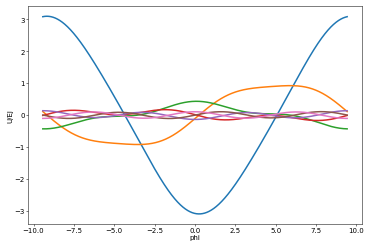

In [258]:
phis = np.linspace(-3*np.pi,3*np.pi,10001)

PhiE = 0.33
alpha = 0.1
m = 3

SNAIL = Snail(alpha = alpha, n = m, phi_E = PhiE)

plt.plot(phis,SNAIL.U(phis))
plt.ylabel('U/EJ')
plt.xlabel('phi')
plt.plot(phis,SNAIL.U_der(phis))
plt.plot(phis,SNAIL.U_der2(phis))
plt.plot(phis,SNAIL.U_der3(phis))
plt.plot(phis,SNAIL.U_der4(phis))
plt.plot(phis,SNAIL.U_der5(phis))
plt.plot(phis,SNAIL.U_der6(phis))


In [66]:
idx = list(SNAIL.U(phis)).index(np.min(SNAIL.U(phis)))

In [263]:
SNAIL.g_4

AttributeError: 'Snail' object has no attribute 'g_4'

In [67]:
print(phis[idx])
print(SNAIL.U(phis[idx]))

0.2544690049407734
-3.095828938388398


In [68]:
f0 = SNAIL.U(phis[idx])
f1 = SNAIL.U_der(phis[idx])
f2 = SNAIL.U_der2(phis[idx])
f3 = SNAIL.U_der3(phis[idx])
f4 = SNAIL.U_der4(phis[idx])
f5 = SNAIL.U_der5(phis[idx])
f6 = SNAIL.U_der6(phis[idx])

In [182]:
poly2 = f0 * (phis-phis[idx])**0 + f1 * (phis-phis[idx]) + f2/math.factorial(2) * (phis-phis[idx])**2 
poly4 = poly2 + f3/math.factorial(3) * (phis-phis[idx])**3 + f4/math.factorial(4) * (phis-phis[idx])**4
poly6 = poly4 + f5/math.factorial(5) * (phis-phis[idx])**5 + f6/math.factorial(6) * (phis-phis[idx])**6

(-4.0, 4.0)

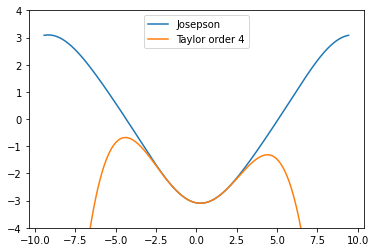

In [184]:
plt.plot(phis,SNAIL.U(phis),label = 'Josepson')
plt.plot(phis,poly, label = 'Taylor order 4')
plt.legend()
plt.ylim(-4,4)

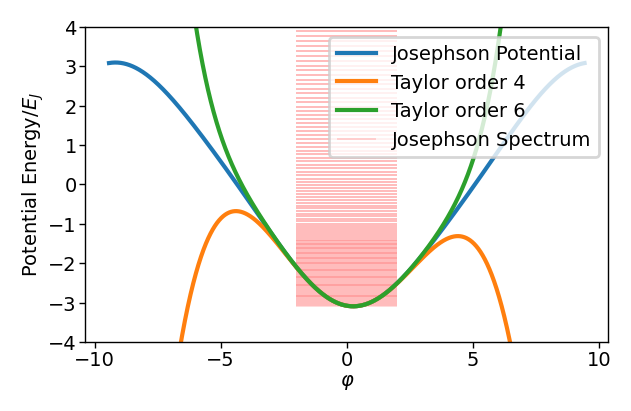

In [246]:
N_basis = 2000

plt.figure(1,figsize=(3.375,3.375/1.618),dpi = 200)

N_op = np.diag(np.linspace(-N_basis/2,N_basis/2,N_basis+1)) 

expTheta = 1j*np.zeros((N_basis+1,N_basis+1))

for i in range(len(expTheta)-1):
    expTheta[i+1,i] = 1
expTheta[0,N_basis]=1

cosTheta = (expTheta + np.linalg.inv(expTheta))/2

expTheta_m = spy.linalg.fractional_matrix_power(np.exp(-1j * PhiE) * expTheta,1/m)
cosTheta_PhiExt_m = (expTheta_m + np.linalg.inv(expTheta_m))/2

E_J = 1
E_C = 1/5907

H = 4 * E_C * N_op @ N_op - alpha * E_J * cosTheta - m * E_J * cosTheta_PhiExt_m

Pot = - alpha * E_J * np.cos(phis) - m * E_J * np.cos((PhiE - phis)/m)

# plt.plot(phis,SNAIL.U(phis),label = 'Josepson',color= 'red')
plt.plot(phis,Pot,'-',label = 'Josephson Potential')
mpl.pyplot.hlines(np.linalg.eigh(H)[0],-2,2,color='red',label ='Josephson Spectrum',linewidth = 0.1)

# plt.ylim(-3.15,-2.8)
plt.ylim(-4,4)

plt.plot(phis,poly4, label = 'Taylor order 4')
plt.plot(phis,poly6, label = 'Taylor order 6')

plt.xlabel(r'$\varphi$')
plt.ylabel(r'Potential Energy/$E_J$')
plt.legend(loc = 1)
# plt.plot(np.linalg.eigh(H)[0])
# plt.ylim(-5,15)

In [247]:
np.sum(np.linalg.eigh(H)[0]<3)

179

In [248]:
np.sum(np.linalg.eigh(H)[0]<-1.5)

72

In [254]:
a = qt.destroy(N_basis)
adag = a.dag()

phi_bos = (a + adag)/np.sqrt(2) 

N_bos = -1j*(a - adag)/np.sqrt(2)

poly_bos2 = f0 * (phi_bos)**0 + f1 * (phi_bos) + f2/math.factorial(2) * (phi_bos)**2 
poly_bos4 = poly_bos2  + f3/math.factorial(3) * (phi_bos)**3 + f4/math.factorial(4) * (phi_bos)**4
poly_bos6 = poly_bos4 + f5/math.factorial(5) * (phi_bos)**5 + f6/math.factorial(6) * (phi_bos)**6

H_bos = 4*E_C*N_bos**2 + poly_bos6
# plt.plot(np.linalg.eigh(H_bos)[0],'o')
# plt.ylim(-5,15)

(-2.0, 100.0)

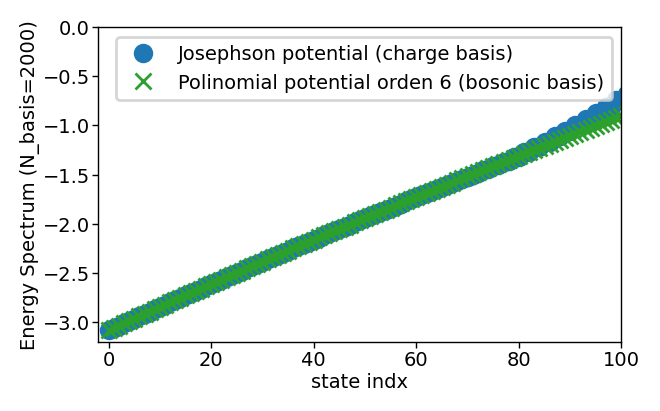

In [264]:
plt.figure(1,figsize=(3.375,3.375/1.618),dpi = 200)

plt.plot(np.linalg.eigh(H)[0],'o',label = 'Josephson potential (charge basis)')

plt.plot(np.linalg.eigh(H_bos)[0],'x',color = 'tab:green',label = 'Polinomial potential orden 6 (bosonic basis)')
plt.legend()
plt.xlabel('state indx')
plt.ylabel('Energy Spectrum (N_basis=2000)')
plt.ylim(-3.2,-0)
plt.xlim(-2,100)

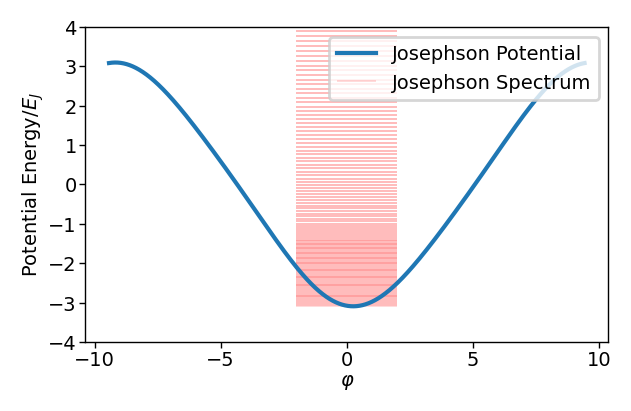

In [257]:
N_basis = 2000

phis = np.linspace(-3*np.pi,3*np.pi,10001)

PhiE = 0.33
alpha = 0.1
m = 3

plt.figure(1,figsize=(3.375,3.375/1.618),dpi = 200)

N_op = np.diag(np.linspace(-N_basis/2,N_basis/2,N_basis+1)) 

expTheta = 1j*np.zeros((N_basis+1,N_basis+1))

for i in range(len(expTheta)-1):
    expTheta[i+1,i] = 1
expTheta[0,N_basis]=1

cosTheta = (expTheta + np.linalg.inv(expTheta))/2

expTheta_m = spy.linalg.fractional_matrix_power(np.exp(-1j * PhiE) * expTheta,1/m)
cosTheta_PhiExt_m = (expTheta_m + np.linalg.inv(expTheta_m))/2

E_J = 1
E_C = 1/5907

H = 4 * E_C * N_op @ N_op - alpha * E_J * cosTheta - m * E_J * cosTheta_PhiExt_m

Pot = - alpha * E_J * np.cos(phis) - m * E_J * np.cos((PhiE - phis)/m)

plt.plot(phis,Pot,'-',label = 'Josephson Potential')
mpl.pyplot.hlines(np.linalg.eigh(H)[0],-2,2,color='red',label ='Josephson Spectrum',linewidth = 0.1)

# plt.ylim(-3.15,-2.8)
plt.ylim(-4,4)


plt.xlabel(r'$\varphi$')
plt.ylabel(r'Potential Energy/$E_J$')
plt.legend(loc = 1)

In [314]:
C = 0.21e-12
L_j = 0.3e-9 #0.9e-9
L_lin = 200e-12
    
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=2).g3)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=2).g4)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=2).g5)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=2).g6)

-18666304.829773717
-2522017.9197170506
6640.982984211639
361.1563872022784


In [319]:
SnailCircuit(L_lin, C , L_j, SNAIL, M=2).omega*1e-9/2/np.pi


8.695327093422103

In [322]:
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=1).c3)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=1).c4)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=1).c5)
print(SnailCircuit(L_lin, C , L_j, SNAIL, M=1).c6)

-0.010504597725724634
-0.04910437942526583
0.004406552795493862
0.01046563224892056


In [325]:
print(f0)
print(f1)
print(f2)
print(f3)
print(f4)
print(f5)
print(f6)

-3.095828938388398
-1.183699345267547e-06
0.43000740207238786
-0.022376006137272503
-0.1338050091483867
0.024862360563563366
0.100893632156831


In [324]:
print(SNAIL.c3)
print(SNAIL.c4)
print(SNAIL.c5)
print(SNAIL.c6)

-0.022376006137272503
-0.1338050091483867
0.024862360563563366
0.100893632156831
